 ## Imports


In [7]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

### Dictionary for easier access to inputs

In [8]:
inputs = {
    "input_1": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/100001/100001_ECG",
    "input_2": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/100002/100002_ECG",
    "input_3": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/103001/103001_ECG",
    "input_4": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/103002/103002_ECG",
    "input_5": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/103003/103003_ECG",
    "input_6": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/104001/104001_ECG",
    "input_7": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/105001/105001_ECG",
    "input_8": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/111001/111001_ECG",
    "input_9": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/113001/113001_ECG",
    "input_10": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/114001/114001_ECG",
    "input_11": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/115001/115001_ECG",
    "input_12": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/118001/118001_ECG",
    "input_13": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/121001/121001_ECG",
    "input_14": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/122001/122001_ECG",
    "input_15": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/123001/123001_ECG",
    "input_16": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/124001/124001_ECG",
    "input_17": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/125001/125001_ECG",
    "input_18": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/126001/126001_ECG"
}


## Functions

### Same functions as 1.1

In [9]:
def load_data(path, duration=None):
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        fs = fields["fs"]
        if duration:
            max_samples = int(fs * duration)
            ecg = ecg[:max_samples]  # Limit duration
        return ecg, fs, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None



def clamp_outliers(signal, max_amp=5000):
    clamped_signal = []
    for value in signal:
        if value > max_amp:
            clamped_signal.append(max_amp)
        elif value < -max_amp:
            clamped_signal.append(-max_amp)
        else:
            clamped_signal.append(value)
    return np.array(clamped_signal)

def high_pass_filter(signal, samp_rate, cutoff_freq=1.0):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 0.5 / samp_rate)
    y = np.zeros_like(signal)
    for i in range(1, len(signal)):
        y[i] = alpha * (y[i - 1] + signal[i] - signal[i - 1])
    return y

def estimate_dynamic_threshold(signal, window_size=1000, perc=95):
    threshold = np.zeros(len(signal))
    half_window = window_size // 2
    for i in range(half_window, len(signal) - half_window):
        window = signal[i - half_window:i + half_window]
        threshold[i] = np.percentile(window, perc)
    return threshold

def calculate_slope(signal):
    slope = [signal[i] - signal[i - 1] for i in range(1, len(signal))]
    return np.array(slope)

def precompute_rolling_max(signal, window_size=1000, step_size=100):
    rolling_max = []
    for i in range(0, len(signal), step_size):
        window = signal[max(0, i - window_size):i + window_size]
        rolling_max.append(max(window))
    return np.array(rolling_max)

def find_Rpeaks(signal):
    dynamic_threshold = estimate_dynamic_threshold(signal)
    rolling_max = precompute_rolling_max(signal)
    slope = calculate_slope(signal)
    peaks = []
    min_distance = int(0.2 * fields["fs"])  # minimum distance is 200ms

    for i in range(1, len(signal) - 1):
        adaptive_threshold = 0.2 * rolling_max[min(i // 100, len(rolling_max) - 1)]
        if signal[i] > adaptive_threshold and signal[i] > dynamic_threshold[i] and slope[i - 1] > 0 and slope[i] < 0:
            if not peaks or (i - peaks[-1]) > min_distance:
                peaks.append(i)
    return np.array(peaks)



def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    signal_duration = len(signal) / samp_rate  # signal in seconds
    window_duration = 15.0  # window length
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def smooth_bpm(bpm_values, window_size=5):
    smoothed_bpm = []
    for i in range(len(bpm_values)):
        window = bpm_values[max(0, i - window_size):i + 1]
        smoothed_bpm.append(np.mean(window))
    return np.array(smoothed_bpm)

def plot_bpm_over_time(bpm_values, driver, window_duration=15.0):
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v závislosti na čase pro měření ' + driver)
    plt.xlabel('Čas (minuty)')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

def plot_ecg_zoomed(signal, r_peaks, samp_rate, start_time, duration=20, title="Zoomed ECG (20 Seconds)"):
    start_sample = int(start_time * samp_rate)
    end_sample = int((start_time + duration) * samp_rate)
    time = np.arange(start_sample, end_sample) / samp_rate  # Time for zoomed window
    
    plt.figure(figsize=(15, 6))
    plt.plot(time, signal[start_sample:end_sample], label="ECG Signal", color='b')
    
    # sanity check
    zoomed_r_peaks = [p for p in r_peaks if start_sample <= p < end_sample]
    plt.scatter(
        np.array(zoomed_r_peaks) / samp_rate, 
        signal[zoomed_r_peaks], 
        color='r', marker='o', label="R-Peaks"
    )
    
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


### Functions for detecting anomalies

In [10]:

def compute_std_online(signal, current_idx, window_size):
    if current_idx < window_size:
        std_dev = np.std(signal[:current_idx + 1])
    else:
        window = signal[current_idx - window_size + 1:current_idx + 1]
        std_dev = np.std(window)  # compute standart deviation
    return std_dev

def smooth_history(history, window_size=20):
    smoothed = []
    for i in range(len(history)):
        start = max(0, i - window_size // 2)
        end = min(len(history), i + window_size // 2 + 1)
        window = history[start:end]
        avg = sum(window) / len(window)
        smoothed.append(avg) # Manual moving average
    return smoothed
    
def calculate_qrs_duration(signal, r_peaks, samp_rate, threshold_ms=120):
    qrs_durations = []
    anomalies = []
    threshold_samples = int((threshold_ms / 1000) * samp_rate)  # Convert threshold to samples

    for r_peak in r_peaks:
        # window around R-peak
        start = max(0, r_peak - int(0.05 * samp_rate))
        end = min(len(signal), r_peak + int(0.1 * samp_rate))
        segment = signal[start:end]

        # Q and S is local minimum
        q_point = start + np.argmin(segment[:len(segment) // 2])
        s_point = start + np.argmin(segment[len(segment) // 2:]) + len(segment) // 2
        
        # QRS calculation
        qrs_duration_samples = s_point - q_point
        qrs_duration_ms = (qrs_duration_samples / samp_rate) * 1000  # ms conversion
        qrs_durations.append(qrs_duration_ms)

        # Check QRS
        if qrs_duration_ms > threshold_ms:
            anomalies.append((r_peak, qrs_duration_ms))

    return qrs_durations, anomalies

def calculate_rr_intervals(r_peaks, samp_rate):
    rr_intervals = np.diff(r_peaks) / samp_rate * 1000  # ms conversion
    median_rr = np.median(rr_intervals)
    anomaly_indices = []
    
    for i, rr in enumerate(rr_intervals):
        # 30% + - 
        if rr < 0.7 * median_rr or rr > 1.3 * median_rr:
            anomaly_indices.append(r_peaks[i + 1])  # Next R-peak is anomalous
    
    return rr_intervals, anomaly_indices

def detect_anomalies_online(signal, samp_rate, r_peaks, window_size_sec=5, dynamic_factor=3.0):
    window_size = int(window_size_sec * samp_rate)
    std_dev_history = []
    std_anomalies = []
    rr_anomalies = []
    qrs_anomalies = []

    for i in range(len(signal)):
        std_dev = compute_std_online(signal, i, window_size)
        std_dev_history.append(std_dev)

        if i > window_size:
            recent_std_dev = std_dev_history[-window_size:]
            
            # Mean & std
            mean = sum(recent_std_dev) / len(recent_std_dev)
            variance = sum((x - mean) ** 2 for x in recent_std_dev) / len(recent_std_dev)
            std_thresh_high = mean + 3 * (variance ** 0.5)
            std_thresh_low = mean - 3 * (variance ** 0.5)
            
            if std_dev > std_thresh_high or std_dev < std_thresh_low:
                std_anomalies.append(i)

    # RR intervals
    rr_intervals, rr_anomalies = calculate_rr_intervals(r_peaks, samp_rate)

    # QRS duration 
    qrs_durations = []
    for r_peak in r_peaks:
        start = max(0, r_peak - int(0.05 * samp_rate))
        end = min(len(signal), r_peak + int(0.1 * samp_rate))
        segment = signal[start:end]

        q_point = start + np.argmin(segment[:len(segment) // 2])
        s_point = start + np.argmin(segment[len(segment) // 2:]) + len(segment) // 2
        qrs_duration_ms = ((s_point - q_point) / samp_rate) * 1000  # Convert to milliseconds
        qrs_durations.append(qrs_duration_ms)

        if qrs_duration_ms > 120:
            qrs_anomalies.append((r_peak, qrs_duration_ms))

    print(f"Detected {len(std_anomalies)} Std Dev anomalies, {len(rr_anomalies)} RR anomalies, and {len(qrs_anomalies)} QRS anomalies.")
    
    return std_anomalies, rr_anomalies, qrs_anomalies, std_dev_history


def plot_problematic_segment(signal, r_peaks, samp_rate, start_time, end_time, std_anomalies, rr_anomalies, qrs_anomalies):
    start_sample = int(start_time * samp_rate)
    end_sample = int(end_time * samp_rate)
    time = np.arange(start_sample, end_sample) / samp_rate  

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal[start_sample:end_sample], label="ECG Signal", color='b')

 
    zoomed_r_peaks = [p for p in r_peaks if start_sample <= p < end_sample]
    plt.scatter(
        np.array(zoomed_r_peaks) / samp_rate,
        signal[zoomed_r_peaks],
        color='r', marker='o', label="R-Peaks"
    )

    zoomed_std_anomalies = [p for p in std_anomalies if start_sample <= p < end_sample]
    zoomed_rr_anomalies = [p for p in rr_anomalies if start_sample <= p < end_sample]
    zoomed_qrs_anomalies = [p for p, _ in qrs_anomalies if start_sample <= p < end_sample]

    plt.scatter(
        np.array(zoomed_std_anomalies) / samp_rate,
        signal[zoomed_std_anomalies],
        color='orange', marker='x', label="Std Dev Anomalies"
    )

    plt.scatter(
        np.array(zoomed_rr_anomalies) / samp_rate,
        signal[zoomed_rr_anomalies],
        color='yellow', marker='s', label="RR Interval Anomalies"
    )

    plt.scatter(
        np.array(zoomed_qrs_anomalies) / samp_rate,
        signal[zoomed_qrs_anomalies],
        color='green', marker='D', label="QRS Duration Anomalies"
    )

    plt.title(f"Problematic ECG Segment ({start_time}-{end_time} sec)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_anomalies_online(signal, samp_rate, std_anomalies, rr_anomalies, qrs_anomalies, window_size_sec=5):
    time = np.arange(len(signal)) / samp_rate
    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, label="ECG Signal", color='b')

    for idx in std_anomalies:
        start_time = idx / samp_rate
        end_time = (idx + window_size_sec * samp_rate) / samp_rate
        plt.axvspan(start_time, end_time, color='r', alpha=0.3, label='Std Dev Anomaly' if idx == std_anomalies[0] else "")


    # R R intervals in yellow
    for idx in rr_anomalies:
        start_time = idx / samp_rate
        plt.axvline(start_time, color='y', linestyle='--', label='RR Anomaly' if idx == rr_anomalies[0] else "")

    for idx, _ in qrs_anomalies:
        start_time = idx / samp_rate
        plt.axvline(start_time, color='g', linestyle='-.', label='QRS Duration Anomaly' if idx == qrs_anomalies[0][0] else "")


    plt.title("ECG Signal with Detected Anomalies (Std Dev, RR Interval, and QRS Duration)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()



## Execution

Processing the first 5 minute(s) of ECG data.
Detected 486 R-peaks.
Detected 9760 Std Dev anomalies, 69 RR anomalies, and 40 QRS anomalies.
Detected 40 QRS anomalies exceeding 120 ms.


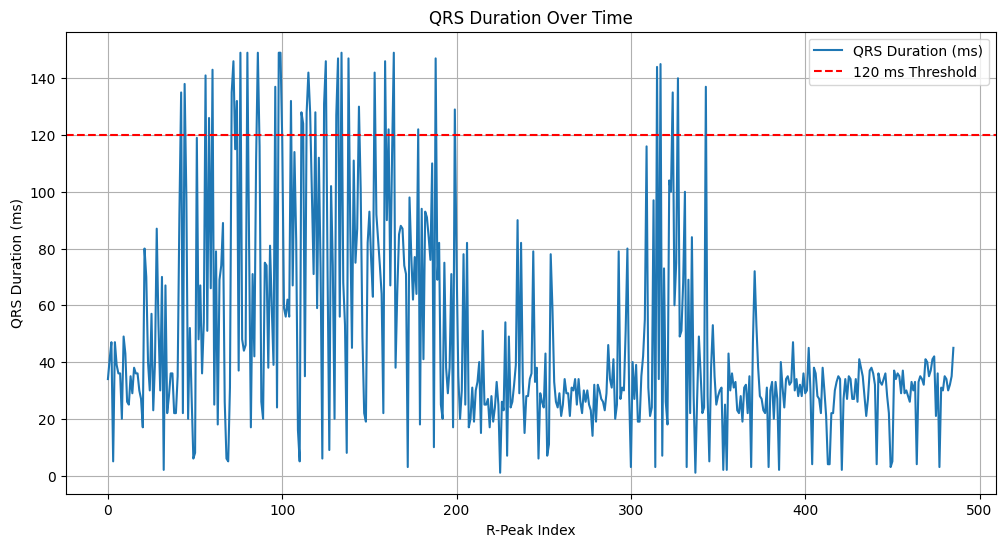

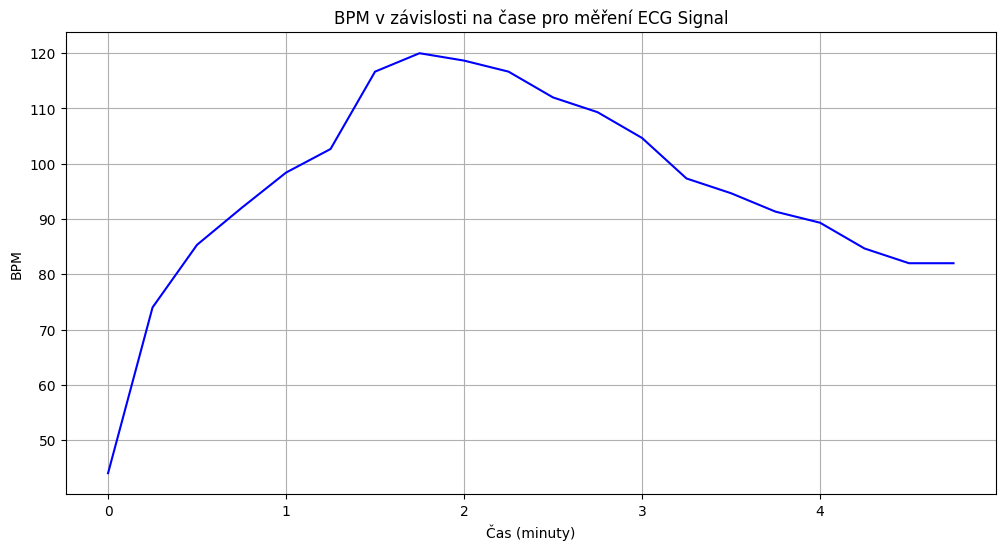

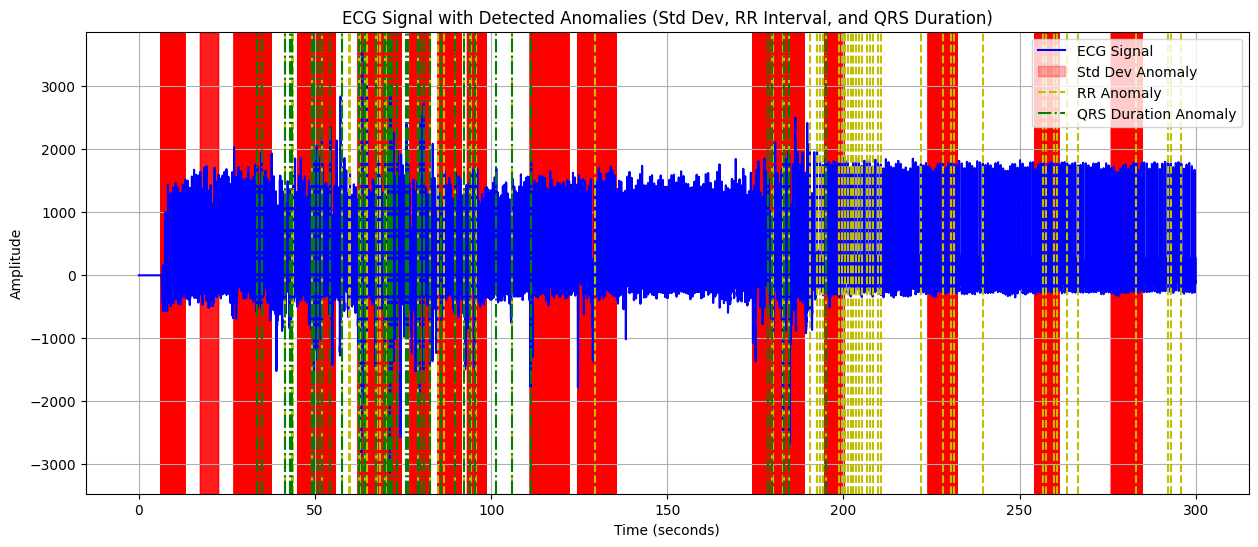

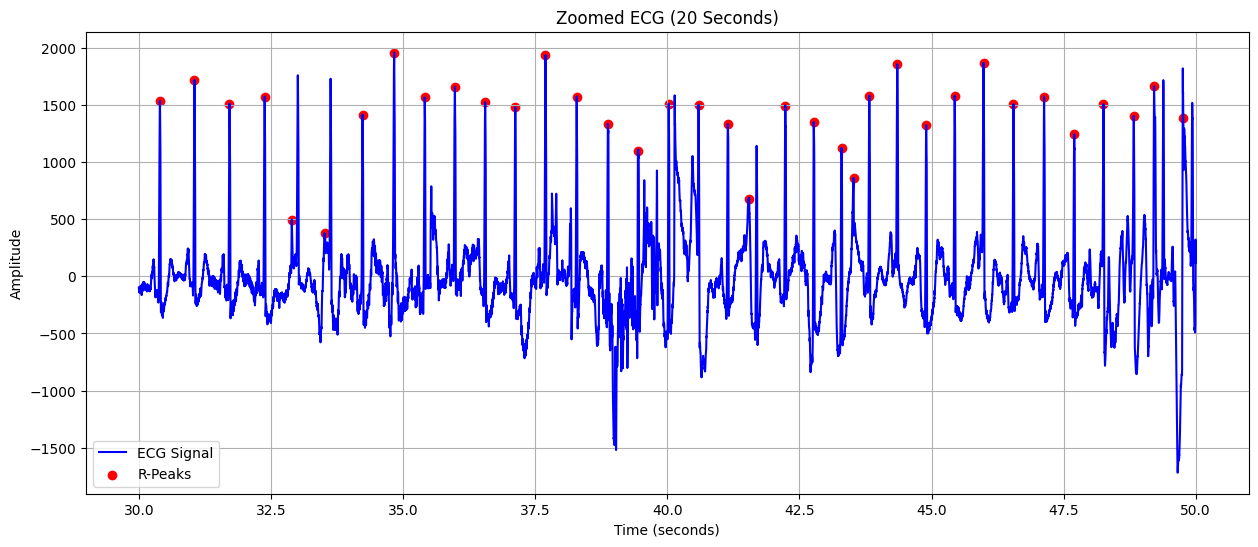

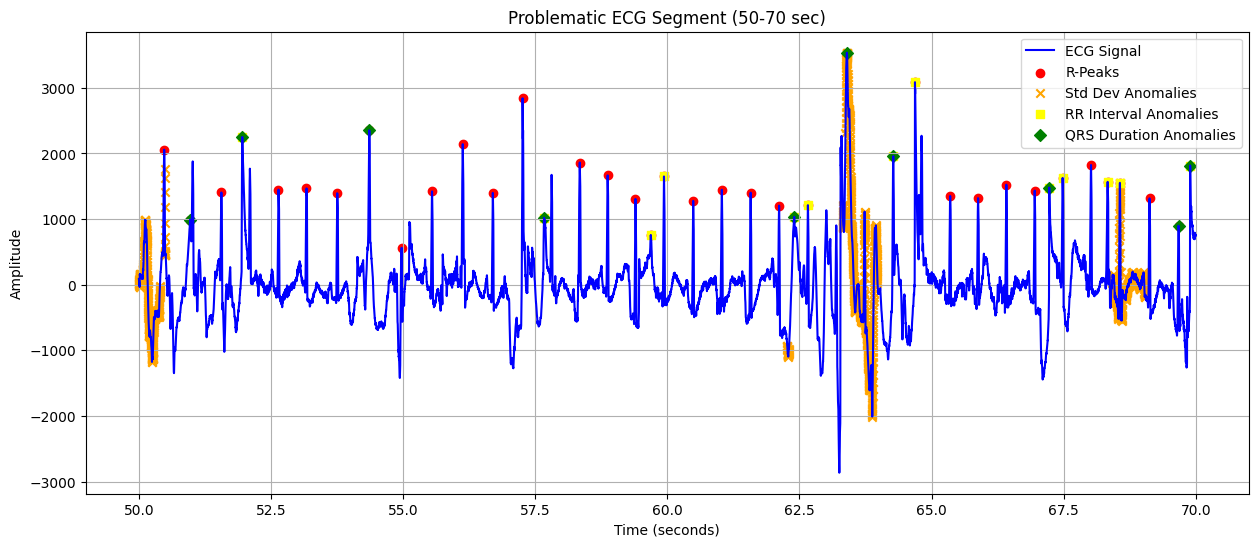

In [11]:
if __name__ == "__main__":
    path = inputs["input_1"]
    duration_minutes = 5
    duration_seconds = duration_minutes * 60

    ecg_signal, samp_rate, fields = load_data(path, duration=duration_seconds)
    if ecg_signal is None:
        print("Failed to load ECG data.")
        exit()

    print(f"Processing the first {duration_minutes} minute(s) of ECG data.")

    clamped_signal = clamp_outliers(ecg_signal, max_amp=5000)
    filtered_signal = high_pass_filter(clamped_signal, samp_rate, cutoff_freq=1.0)
    r_peaks = find_Rpeaks(filtered_signal)
    print(f"Detected {len(r_peaks)} R-peaks.")

    anomaly_indices, rr_anomalies, qrs_anomalies, std_dev_history = detect_anomalies_online(
    filtered_signal, samp_rate, r_peaks, window_size_sec=5, dynamic_factor=3.0
    )
    

    qrs_durations, qrs_anomalies = calculate_qrs_duration(filtered_signal, r_peaks, samp_rate, threshold_ms=120)
    print(f"Detected {len(qrs_anomalies)} QRS anomalies exceeding 120 ms.")

    plt.figure(figsize=(12, 6))
    plt.plot(qrs_durations, label="QRS Duration (ms)")
    plt.axhline(120, color='r', linestyle='--', label="120 ms Threshold")
    plt.title("QRS Duration Over Time")
    plt.xlabel("R-Peak Index")
    plt.ylabel("QRS Duration (ms)")
    plt.legend()
    plt.grid(True)
    plt.show()

    r_peak_counts = count_rpeaks_in_windows(filtered_signal, r_peaks, samp_rate)
    bpm_values = [count * (60 / 15.0) for count in r_peak_counts]
    smoothed_bpm = smooth_bpm(bpm_values)
    plot_bpm_over_time(smoothed_bpm, driver="ECG Signal", window_duration=15.0)

    plot_anomalies_online(filtered_signal, samp_rate, anomaly_indices, rr_anomalies, qrs_anomalies, window_size_sec=5)
    plot_ecg_zoomed(filtered_signal, r_peaks, samp_rate, start_time=30, duration=20)

    plot_problematic_segment(filtered_signal, r_peaks, samp_rate, start_time=50, end_time=70, 
                         std_anomalies=anomaly_indices, rr_anomalies=rr_anomalies, qrs_anomalies=qrs_anomalies)
